# Attention-based multihead convolution long-short term memory network for RUL prediction

In [1]:
!pip install keras==2.4.3

In [2]:
!pip install tensorflow==2.3.1.

In [3]:
!pip install keras_self_attention

In [4]:
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Conv1D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras_self_attention
from sklearn import preprocessing

In [5]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D
from keras.layers.merge import concatenate
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import LSTM 
from keras.layers import Attention
from keras_self_attention import SeqSelfAttention
import pydot_ng as pydot
import pydotplus
import graphviz

os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

## Mount the dataset on a drive or specify path

In [6]:
# In the NASA dataset, there are four data subsets (FD001-4). 
# This function is developed to handle any of the data subsets.

In [8]:
def read_data(filename):

    """function to turn the dataset into dataframe with column headings"""

    train_df = pd.read_csv(
        "/content/sample_data/train_" + filename + ".txt", sep=" ", header=None
    )
    train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
    train_df.columns = [
        "id",
        "cycle",
        "setting1",
        "setting2",
        "setting3",
        "s1",
        "s2",
        "s3",
        "s4",
        "s5",
        "s6",
        "s7",
        "s8",
        "s9",
        "s10",
        "s11",
        "s12",
        "s13",
        "s14",
        "s15",
        "s16",
        "s17",
        "s18",
        "s19",
        "s20",
        "s21",
    ]

    train_df = train_df.sort_values(["id", "cycle"])

    test_df = pd.read_csv(
        "/content/sample_data/test_" + filename + ".txt", sep=" ", header=None
    )
    test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
    test_df.columns = [
        "id",
        "cycle",
        "setting1",
        "setting2",
        "setting3",
        "s1",
        "s2",
        "s3",
        "s4",
        "s5",
        "s6",
        "s7",
        "s8",
        "s9",
        "s10",
        "s11",
        "s12",
        "s13",
        "s14",
        "s15",
        "s16",
        "s17",
        "s18",
        "s19",
        "s20",
        "s21",
    ]

    truth_df = pd.read_csv(
        "/content/sample_data/RUL_" + filename + ".txt", sep=" ", header=None
    )
    truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
    return train_df, test_df, truth_df


In [9]:
#Specify the data subset to use for training
filename= "FD001"

In [10]:
# Model can be trained using a set of time windows
# ranging from 20 to 120. Specify the window length

sequence_length = 90

# Not all columns in the dataset is used. Select useful signals in the dataset

sequence_cols = ["s" + str(i) for i in set(range(1, 22))] + [
    "setting1",
    "setting2",
    "setting3",
    "cycle_norm",
]

if filename == "FD001":
    cycle = 130
    sequence_cols = [
        x
        for x in sequence_cols
        if x not in ["s1", "s5", "s6", "s10", "s16", "s18", "s19", "setting3"]
    ]
elif filename == "FD003":
    cycle = 130
    sequence_cols = [
        x
        for x in sequence_cols
        if x not in ["s1", "s5", "s16", "s18", "s19", "setting3"]
    ]
else:
    cycle = 130
    sequence_cols = ["s" + str(i) for i in set(range(1, 22))] + [
        "setting1",
        "setting2",
        "setting3",
        "cycle_norm",
    ]


In [11]:
train_df, test_df, truth_df = read_data(filename)

In [12]:
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [13]:
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [14]:
#Preprocess the dataset

In [15]:
# These two functions preprocess the training and test dataset respectively

def train_data_prep(train_df):
      """
       A function to preprocess the training dataset for piece-wise RUL
       estimation
       
       Parameter:
         
         training dataframe (FD001-4)
        
       Returns:
         
         train_df, a preprocessed dataframe with column names
        and target variable.

      """
      rul = pd.DataFrame(train_df.groupby("id")["cycle"].max()).reset_index()
      rul.columns = ["id", "max"]
      train_df = train_df.merge(rul, on=["id"], how="left")
      train_df["RUL"] = train_df["max"] - train_df["cycle"]
      train_df.drop("max", axis=1, inplace=True)
      train_df["R_early"] = train_df["RUL"].apply(lambda x: cycle if x >= cycle else x)
      train_df = train_df.drop(["RUL"], axis=1)
      return train_df

def test_data_prep(test_df, truth_df):
    """
    A function to preprocess the test data subset for
     piece-wise RUL prediction
          
        Parameters:

          truth_df: the actual RUL
          test_df: the test data subset

        Returns:

          test_df: a preprocessed test dataset with piecewise RUL.
          """
    rul = pd.DataFrame(test_df.groupby("id")["cycle"].max()).reset_index()
    rul.columns = ["id", "max"]
    truth_df.columns = ["more"]
    truth_df["id"] = truth_df.index + 1
    truth_df["max"] = rul["max"] + truth_df["more"]
    truth_df.drop("more", axis=1, inplace=True)
    # generate RUL for test data
    test_df = test_df.merge(truth_df, on=["id"], how="left")
    test_df["RUL"] = test_df["max"] - test_df["cycle"]
    test_df.drop("max", axis=1, inplace=True)
    test_df["R_early"] = test_df["RUL"].apply(lambda x: cycle if x >= cycle else x)
    test_df = test_df.drop(["RUL"], axis=1)
    return test_df


In [16]:
train_df = train_data_prep(train_df)

In [17]:
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,R_early
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,130
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,130
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,130
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,130
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,130


In [18]:
test_df= test_data_prep(test_df, truth_df)

In [19]:
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,R_early
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,130
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,130
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,130
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,130
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,130


In [20]:
#Normalize the dataset 

In [21]:
#This function normalizes the training and test dataset.
def train_test_scaler(train_data, test_data):

    """function to standardize the dataset"""

    train_data["cycle_norm"] = train_data["cycle"]
    cols_normalize = train_data.columns.difference(["id", "cycle", "R_early"])
    min_max_scaler = preprocessing.MinMaxScaler()
    norm_train_df = pd.DataFrame(
        min_max_scaler.fit_transform(train_data[cols_normalize]),
        columns=cols_normalize,
        index=train_data.index,
    )
    join_df = train_data[train_data.columns.difference(cols_normalize)].join(
        norm_train_df
    )
    train_df = join_df.reindex(columns=train_data.columns)

    # MinMax normalization (from 0 to 1)
    test_data["cycle_norm"] = test_data["cycle"]
    norm_test_df = pd.DataFrame(
        min_max_scaler.transform(test_data[cols_normalize]),
        columns=cols_normalize,
        index=test_data.index,
    )
    test_join_df = test_data[test_data.columns.difference(cols_normalize)].join(
        norm_test_df
    )
    test_df = test_join_df.reindex(columns=test_data.columns)
    test_df = test_df.reset_index(drop=True)
    return train_df, test_df


In [22]:
train_df, test_df = train_test_scaler(train_df, test_df)

In [23]:
#Generate and reshape the training and test dataset

In [24]:
#These functions reshape the training and test datasets in three dimension

def gen_sequence(id_df, seq_length, seq_cols):

    """
    sequence generator

    Parameters:

        id_df: Engine ID
        seq_length: Sequence length
        seq_cols: Sequence column

    """

    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(
        range(0, num_elements - seq_length), range(seq_length, num_elements)
    ):
        yield data_matrix[start:stop, :]


def sequence_gen(train_data, sequence_length, sequence_cols):

    """
    training sequence generator.

    Returns:
        Generated sequence in the form
        [samples, time_steps, features]

    """
    seq_gen = (
        list(
            gen_sequence(
                train_data[train_data["id"] == id], sequence_length, sequence_cols
            )
        )
        for id in train_data["id"].unique()
    )
    # generate sequences and convert to numpy array
    seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
    return seq_array


# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]


def label_generator(train_data, sequence_length, sequence_cols):
    """ generate labels """
    label_gen = [
        gen_labels(train_data[train_data["id"] == id], sequence_length, ["R_early"])
        for id in train_data["id"].unique()
    ]
    label_array = np.concatenate(label_gen).astype(np.float32)
    return label_array



In [25]:
#Specify training sample, training label
seq_array = sequence_gen(train_df, sequence_length, sequence_cols)
label_array = label_generator(train_df, sequence_length, ['R_early'])
print('Data Shape: ', seq_array.shape)
print('Label Shape: ', label_array.shape)

Data Shape:  (11631, 90, 17)
Label Shape:  (11631, 1)


In [26]:
# Similarly, prepare the test data for model evaluation

In [27]:
# prepare test data for model evaluation
def test_data_eval(test_df, sequence_length, sequence_cols):

    """
    This function pick the last sequence for each
    engine in the test data for model evaluation

    """
    seq_array_test_last = [
        test_df[test_df["id"] == id][sequence_cols].values[-sequence_length:]
        for id in test_df["id"].unique()
        if len(test_df[test_df["id"] == id]) >= sequence_length
    ]
    seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

    y_mask = [
        len(test_df[test_df["id"] == id]) >= sequence_length
        for id in test_df["id"].unique()
    ]
    label_array_test_last = test_df.groupby("id")["R_early"].nth(-1)[y_mask].values
    label_array_test_last = label_array_test_last.reshape(
        label_array_test_last.shape[0], 1
    ).astype(np.float32)
    return seq_array_test_last, label_array_test_last


In [28]:
#Specify test sample, test label
seq_array_test, label_array_test = test_data_eval(test_df, sequence_length, sequence_cols)
print("Data Shape: ", seq_array_test.shape)
print("Label Shape: ", label_array_test.shape)

Data Shape:  (74, 90, 17)
Label Shape:  (74, 1)


In [29]:
#Specify number of timesteps, features, and output
nb_timesteps=seq_array.shape[1]
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

In [30]:
#For conventional models, seq_array, will be used for training, and seq_array_test, will be used for testing
#However, for multihead models, reshape the training sample so that each head is used to learn different features in the training sample

In [31]:
training_sample_multihead = [seq_array[:,:,i].reshape((seq_array.shape[0],sequence_length,1)) for i in range(nb_features)]

In [32]:
test_sample_multihead = test_data = [seq_array_test[:,:,i].reshape((seq_array_test.shape[0],sequence_length,1)) for i in range(nb_features)]

In [33]:
# these are the evaluation metrics for the model
def k_score(y_true, y_pred):

    """score metric used for model evaluation"""

    d = y_pred - y_true
    return K.sum(K.exp(d[d >= 0] / 10) - 1) + K.sum(K.exp(-1 * d[d < 0] / 13) - 1)


def rmse(y_true, y_pred):

    """rmse metric used for model evaluation"""

    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [34]:
#Create attention_based Multihead CNLSTM

In [35]:
#Attention_based multihead CNLSTM
#This is my implemetation of the AMCNLSTM. Feel free to experiment with the architecture

in_layers, out_layers = list(), list()
for i in range(nb_features):
  inputs = Input(shape=(sequence_length,1))
  rnn1 = Conv1D(filters=64,kernel_size=2,strides=1,padding="same")(inputs)
  lr1= LeakyReLU()(rnn1)
  bn1= BatchNormalization()(lr1)
  rnn2 = Conv1D(filters=64,kernel_size=2,strides=1,padding="same")(bn1)
  lr2= LeakyReLU()(rnn2)
  bn2= BatchNormalization()(lr2)
  rnn3 = LSTM(units=50, return_sequences=True)(bn2)
  lr3= LeakyReLU()(rnn3)
  bn3= BatchNormalization()(lr3)
  att = SeqSelfAttention(attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL, kernel_regularizer=keras.regularizers.l2(1e-4), bias_regularizer=keras.regularizers.l1(1e-4), attention_regularizer_weight=1e-4,attention_width=15)(bn3)
  pool1 = MaxPooling1D(pool_size=2)(att)
  flat = Flatten()(pool1)
  # store layers
  in_layers.append(inputs)
  out_layers.append(flat)
# merge heads
merged = concatenate(out_layers)
# interpretation
dense1 = Dense(50, activation='relu')(merged)
outputs = Dense(nb_out)(dense1)
model = Model(inputs=in_layers, outputs=outputs)
optimizer = keras.optimizers.Adam(lr=3e-5)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=[rmse, k_score])

In [36]:
# Creat model checkpoint to save the best model performance
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath="/content/sample_data/" + filename + ".h5", save_best_only=True, verbose=1
)

# specify ealy_callback to stop training model if there's no improvement after 5 epochs
early_stopping = keras.callbacks.EarlyStopping(patience=5)

# Get the model summary
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 90, 1)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 90, 1)]      0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 90, 1)]      0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 90, 1)]      0                                            
_______________________________________________________________________________________

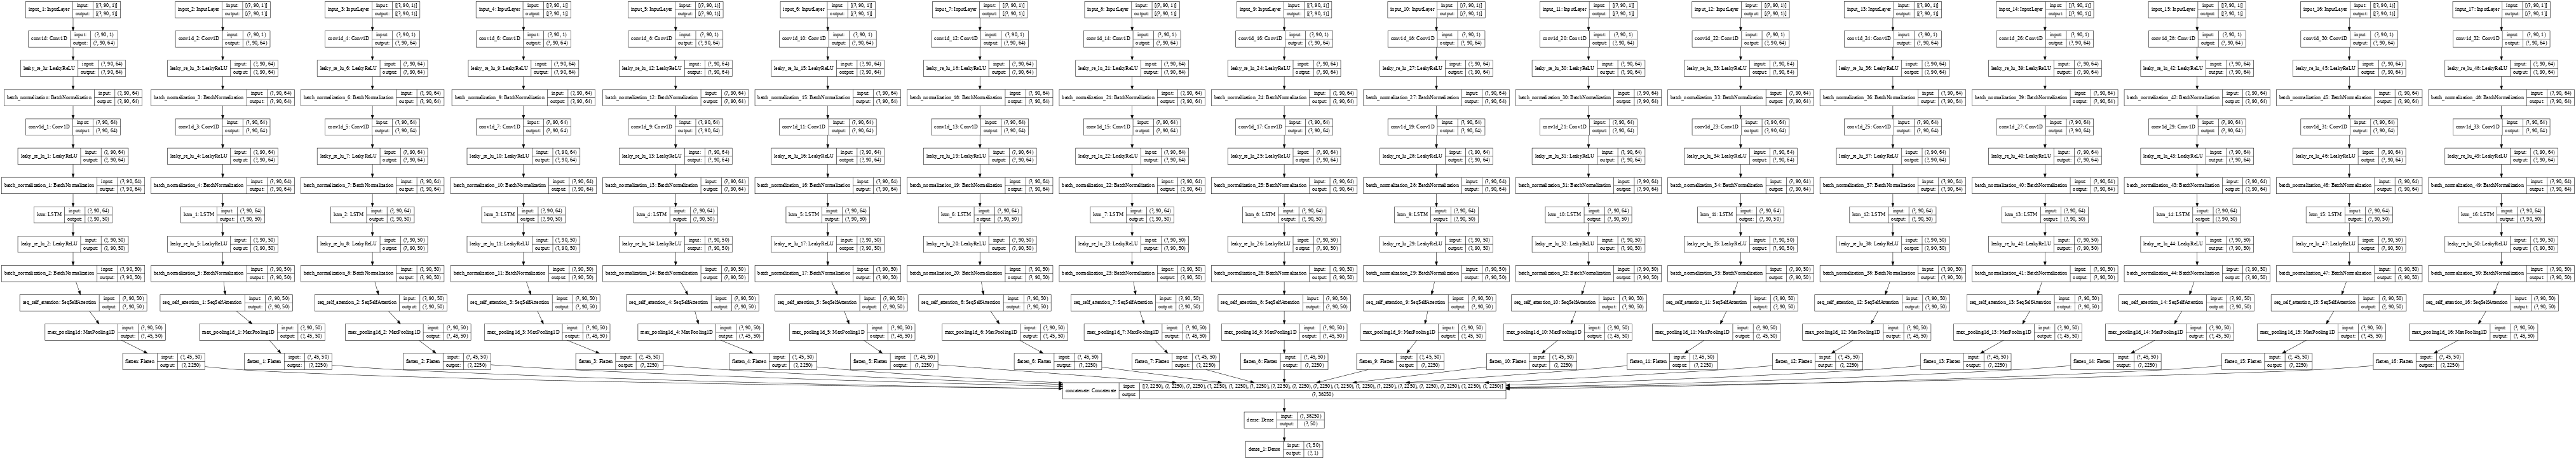

In [37]:
# Plot the model
#It can be seen here that the number of heads= number of features (columns) in the training sample
pydot.find_graphviz()
keras.utils.plot_model(model, show_shapes=True, to_file='AMCNLSTM.png',dpi=40)

In [38]:
#Train the multihead model

train_history=model.fit(training_sample_multihead, label_array, epochs=500,
        validation_split=0.2,callbacks=[early_stopping, model_checkpoint])


Epoch 1/500
291/291 [==============================] - ETA: 0s - loss: 18.7628 - rmse: 24.8932 - k_score: 3326.7478
Epoch 00001: val_loss improved from inf to 50.15706, saving model to /content/sample_data/FD001.h5
291/291 [==============================] - 338s 1s/step - loss: 18.7628 - rmse: 24.8932 - k_score: 3326.7478 - val_loss: 50.1571 - val_rmse: 52.8563 - val_k_score: 26300.0840
Epoch 2/500
291/291 [==============================] - ETA: 0s - loss: 8.8825 - rmse: 12.2625 - k_score: 73.0393
Epoch 00002: val_loss improved from 50.15706 to 24.12217, saving model to /content/sample_data/FD001.h5
291/291 [==============================] - 330s 1s/step - loss: 8.8825 - rmse: 12.2625 - k_score: 73.0393 - val_loss: 24.1222 - val_rmse: 25.2968 - val_k_score: 602.5405
Epoch 3/500
291/291 [==============================] - ETA: 0s - loss: 5.9143 - rmse: 8.1850 - k_score: 34.1684
Epoch 00003: val_loss improved from 24.12217 to 11.24609, saving model to /content/sample_data/FD001.h5
291/291

In [39]:
# load the best checkpoint and evaluate on test set

# This function loads the best model
def load_model_from_disk(filename):

    """Functio to load the best model after training"""

    return load_model(
        "/content/sample_data/" + filename + ".h5",
        custom_objects={"rmse": rmse, "k_score": k_score,"SeqSelfAttention":SeqSelfAttention})

In [40]:
trained_model = load_model_from_disk(filename)

In [41]:
#Evaluate the model on test data
model_evaluation_res = trained_model.evaluate(
    test_sample_multihead, label_array_test, return_dict=True)

3/3 [==============================] - 0s 120ms/step - loss: 9.4827 - rmse: 12.7931 - k_score: 55.7531


In [42]:
# Predict the degradation trend in test data
y_pred = trained_model.predict(test_data)
#y_pred=np.squeeze(y_pred)


In [43]:
#plot the prediction vs the ground truth
def plot_result(y_true, y_pred, title=None):

    """ A function to plot the predicted RUL vs the target RUL for all engines"""

    fig = plt.figure(figsize = (3.5, 2.5))
    plt.grid(True,lw=0.1)
    plt.rcParams['axes.linewidth'] = 0.4  # set the value globally
    plt.plot(y_true, 'r', linewidth=0.5,linestyle='--')
    plt.plot(y_pred, 'k', linewidth=0.5)
    plt.title(title,fontsize=8)
    plt.xlabel('Time (Cycle)', fontsize=7)
    plt.xticks(fontsize=5)
    plt.ylabel('RUL', fontsize=7)
    plt.yticks(fontsize=5)
    plt.legend(['Actual RUL', 'Predicted RUL'],  loc='upper right', fontsize=5)
    plt.show()
    fig.savefig("/content/sample_data/"  + title + '.tiff', dpi=90, format='tiff', bbox_inches='tight')
    return fig


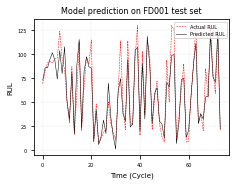

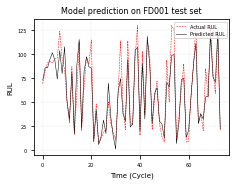

In [44]:
# View the results
plot_result(
    label_array_test, y_pred, title="Model prediction on " + filename + " test set"
)

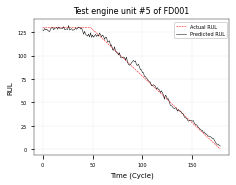

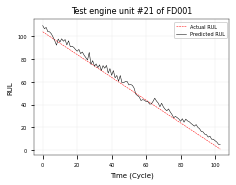

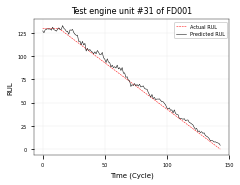

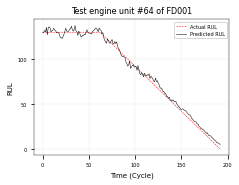

In [45]:

# Test the model on randomly selected engine from the test dataset

if filename == "FD001":
    eng_no = [5,21,31,64]
elif filename =="FD002":
    eng_no= [11,31]
elif filename=="FD003":
    eng_no=[4,10,34,71,96]
else:
    eng_no= [1,37]   

for numb in eng_no:
    eng_df = pd.read_csv(
        "/content/sample_data/Eng_plot_" + str(numb) + "_" + filename + ".csv"
    )
    seq_array_eng = sequence_gen(eng_df, sequence_length, sequence_cols)
    seq_array_eng2 = [seq_array_eng[:,:,i].reshape((seq_array_eng.shape[0],sequence_length,1)) for i in range(nb_features)]
    label_array_eng = label_generator(eng_df, sequence_length, ["R_early"])
    y_pred_eng = trained_model.predict(seq_array_eng2)
    #y_pred_eng = best_model.predict(seq_array_eng)
    y_pred_eng=np.squeeze(y_pred_eng)
    plot_result(
        label_array_eng,
        y_pred_eng,
        title="Test engine unit #" + str(numb) + " " + "of" + " " + filename,
    )